<a href="https://colab.research.google.com/github/aasr-1001/Datathon/blob/main/Copy_of_DATATHON_GIS_ANALYSIS_USING_PROXIMITY_AND_FEATURES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
train_columns = []

def encode_categoricals_with_label(df, is_train=True):
    skip_encoding = ["Neighborhood"]
    categorical_cols = df.select_dtypes(include="object").columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in skip_encoding]

    if is_train:
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    else:
        for col in categorical_cols:
            le = label_encoders.get(col)
            if le:
                df[col] = df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
            else:
                df[col] = -1

    return df


def treat_outliers(df, numerical_cols):
    features_to_skip = []
    for col in numerical_cols:
        non_zero_before = (df[col] != 0).sum()

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        non_zero_after = (df_filtered[col] != 0).sum()

        if non_zero_before > 0 and (non_zero_after / non_zero_before) < 0.7:
            features_to_skip.append(col)

    print("Skipping outlier detection for:", features_to_skip)
    numerical_cols_to_check = [col for col in numerical_cols if col not in features_to_skip]

    Q1 = df[numerical_cols_to_check].quantile(0.25)
    Q3 = df[numerical_cols_to_check].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for col in numerical_cols_to_check:
        df[col] = df[col].clip(lower=lower_bound[col], upper=upper_bound[col])

    return df

def preprocess_train(df):
    global train_columns

    df.drop(columns=["Id"], inplace=True)

    missing = df.isnull().mean()
    df.drop(columns=missing[missing > 0.5].index, inplace=True)

    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
    df[categorical_cols] = df[categorical_cols].fillna("Missing")


    variances = df[numerical_cols].var()
    low_variance_cols = variances[variances < 0.01].index.tolist()
    df.drop(columns=low_variance_cols, inplace=True)
    numerical_cols = [col for col in numerical_cols if col not in low_variance_cols]

    # Outliers
    df = treat_outliers(df, numerical_cols)


    df = encode_categoricals_with_label(df, is_train=True)

    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    df["Age"] = df["YrSold"] - df["YearBuilt"]
    df["TotalBath"] = df["FullBath"] + (0.5 * df["HalfBath"]) + df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"])
    df["PorchArea"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]

    train_columns = df.columns.tolist()

    df.to_csv('/content/drive/MyDrive/train_processed.csv', index=False)
    print("Train preprocessing complete. Saved as 'train_processed.csv'.")
    return df

def preprocess_test(df):
    df.drop(columns=["Id"], inplace=True)

    missing = df.isnull().mean()
    df.drop(columns=missing[missing > 0.5].index, inplace=True)

    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
    df[categorical_cols] = df[categorical_cols].fillna("Missing")

    variances = df[numerical_cols].var()
    low_variance_cols = variances[variances < 0.01].index.tolist()
    df.drop(columns=low_variance_cols, inplace=True)
    numerical_cols = [col for col in numerical_cols if col not in low_variance_cols]

    df = treat_outliers(df, numerical_cols)

    df = encode_categoricals_with_label(df, is_train=False)

    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    df["Age"] = df["YrSold"] - df["YearBuilt"]
    df["TotalBath"] = df["FullBath"] + (0.5 * df["HalfBath"]) + df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"])
    df["PorchArea"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]

    df = df.reindex(columns=train_columns, fill_value=0)

    df.to_csv('/content/drive/MyDrive/test_processed.csv', index=False)
    print("Test preprocessing complete. Saved as 'test_processed.csv'.")
    return df

train_df = pd.read_csv("/content/drive/MyDrive/PS4/train.csv")
train_processed = preprocess_train(train_df)

test_df = pd.read_csv("/content/drive/MyDrive/PS4/test.csv")
test_processed = preprocess_test(test_df)

print(train_processed.shape, test_processed.shape)

#/content/drive/MyDrive/train_processed.csv
#/content/drive/MyDrive/test_processed.csv

Skipping outlier detection for: ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
Train preprocessing complete. Saved as 'train_processed.csv'.
Skipping outlier detection for: ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
Test preprocessing complete. Saved as 'test_processed.csv'.
(1460, 79) (1459, 79)


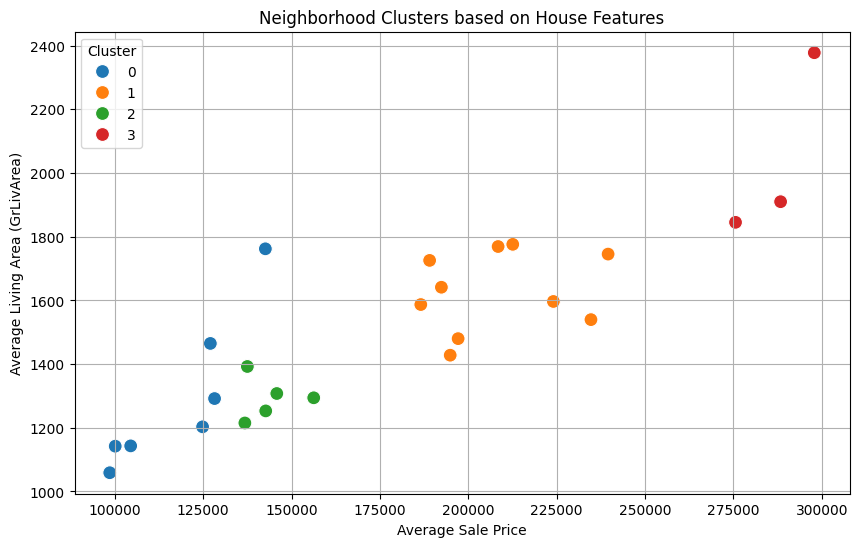


 Cluster-wise Neighborhood Summary:


,Neighborhood,SalePrice,GrLivArea,OverallQual,TotalBsmtSF,GarageArea,YearBuilt,Cluster
2,BrDale,104493.750000,1143.187500,5.687500,583.875000,284.000000,1971.437500,0
3,BrkSide,124834.051724,1203.068966,5.068966,767.586207,303.241379,1931.431034,0
18,SWISU,142591.360000,1761.970000,5.440000,847.080000,281.600000,1925.240000,0
17,OldTown,127030.942478,1464.880531,5.389381,810.973451,382.123894,1923.203540,0
7,Edwards,128219.700000,1291.812500,5.090000,853.000000,321.402500,1955.970000,0
9,IDOTRR,100123.783784,1142.297297,4.756757,747.972973,307.628378,1927.945946,0
10,MeadowV,98576.470588,1058.941176,4.470588,653.352941,259.470588,1972.588235,0
0,Blmngtn,194870.882353,1427.941176,7.176471,1324.411765,502.764706,2005.235294,1
21,Somerst,224056.546512,1596.651163,7.337209,1132.755814,624.607558,2004.988372,1
20,SawyerW,186555.796610,1586.976695,6.322034,1028.576271,499.000000,1988.559322,1


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/drive/MyDrive/train_processed.csv')

df.dropna(inplace=True)  #NOT NEEDED- REMOVE LATER
neighborhood_stats = df.groupby('Neighborhood').agg({
    'SalePrice': 'mean',
    'GrLivArea': 'mean',
    'OverallQual': 'mean',
    'TotalBsmtSF': 'mean',
    'GarageArea': 'mean',
    'YearBuilt': 'mean'
}).reset_index()

features = ['SalePrice', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'GarageArea', 'YearBuilt']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(neighborhood_stats[features])

kmeans = KMeans(n_clusters=4, random_state=42)
neighborhood_stats['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=neighborhood_stats, x='SalePrice', y='GrLivArea', hue='Cluster', palette='tab10', s=100)
plt.title('Neighborhood Clusters based on House Features')
plt.xlabel('Average Sale Price')
plt.ylabel('Average Living Area (GrLivArea)')
plt.grid(True)
plt.show()

print("\n Cluster-wise Neighborhood Summary:")
display(neighborhood_stats.sort_values('Cluster'))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import ipywidgets as widgets
from IPython.display import display, HTML
file_path = "/content/drive/MyDrive/train_processed.csv"
neighborhood_mapping_path = "/content/drive/MyDrive/neighborhood_mapping.csv"
df = pd.read_csv(file_path)
df_neighborhood_mapping = pd.read_csv(neighborhood_mapping_path)

neighborhood_dict = dict(zip(df_neighborhood_mapping["n_names"], df_neighborhood_mapping["n_encode"]))
df["Neighborhood"] = df["Neighborhood"].map(neighborhood_dict)

df = df.dropna()

# Define features and target variable
features = ["Neighborhood", "TotalSF", "OverallQual", "Age", "TotalBath", "PorchArea"]
target_price = "SalePrice"

df = df[features + [target_price]]

# Split dataset
X = df.drop(columns=[target_price])
y_price = df[target_price]
X_train, X_test, y_train_price, y_test_price = train_test_split(
    X, y_price, test_size=0.2, random_state=42
)

price_model = RandomForestRegressor(random_state=42)
price_model.fit(X_train, y_train_price)

y_pred = price_model.predict(X_test)
r2 = r2_score(y_test_price, y_pred)
print(f"R2 Score of the model: {r2:.4f}")
#UI
neighborhood_dropdown = widgets.Dropdown(options=list(neighborhood_dict.keys()), description="Neighborhood:")
total_sf_slider = widgets.IntSlider(min=500, max=6000, step=100, description="Total SF:")
overall_qual_slider = widgets.IntSlider(min=1, max=10, step=1, description="Overall Quality:")
age_slider = widgets.IntSlider(min=0, max=100, step=1, description="Age:")
total_bath_slider = widgets.FloatSlider(min=1, max=5, step=0.5, description="Total Baths:")
porch_area_slider = widgets.IntSlider(min=0, max=500, step=10, description="Porch Area:")
submit_button = widgets.Button(description="Predict Price", button_style="success")

# Styling
output = widgets.Output()

def on_submit_clicked(b):
    selected_neighborhood = neighborhood_dropdown.value
    encoded_neighborhood = neighborhood_dict[selected_neighborhood]
    total_sf = total_sf_slider.value
    overall_qual = overall_qual_slider.value
    age = age_slider.value
    total_bath = total_bath_slider.value
    porch_area = porch_area_slider.value

    user_input_features = np.array([
        encoded_neighborhood, total_sf, overall_qual, age, total_bath, porch_area
    ]).reshape(1, -1)

    predicted_price = price_model.predict(user_input_features)[0]

    # Clear previous output and display styled result
    with output:
        output.clear_output()
        display(HTML(f"""
        <div style="
            background-color: #f8f9fa;
            border-left: 6px solid #28a745;
            padding: 15px;
            margin-top: 10px;
            font-size: 16px;
            font-family: Arial, sans-serif;
            border-radius: 5px;
        ">
            <strong>Estimated House Price:</strong>
            <span style="color: #28a745; font-size: 20px;">${predicted_price:,.2f}</span>
        </div>
        """))

submit_button.on_click(on_submit_clicked)

display(
    widgets.VBox([
        neighborhood_dropdown,
        total_sf_slider,
        overall_qual_slider,
        age_slider,
        total_bath_slider,
        porch_area_slider,
        submit_button,
        output
    ])
)


R2 Score of the model: 0.8968


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import folium
import random

neighborhood_coords = {
    "NWAmes": (42.0535, -93.6566),
    "Veenker": (42.0474, -93.6663),
    "MeadowV": (42.0330, -93.6390),
    "NAmes": (42.0561, -93.6133),
    "BrDale": (42.0503, -93.6266),
    "Timber": (42.0414, -93.6757),
    "BrkSide": (42.0302, -93.6202),
    "SawyerW": (42.0358, -93.6850),
    "Blmngtn": (42.0515, -93.6694),
    "NridgHt": (42.0603, -93.6565),
    "SWISU": (42.0176, -93.6511),
    "NoRidge": (42.0619, -93.6620),
    "Mitchel": (42.0410, -93.6732),
    "Crawfor": (42.0259, -93.6436),
    "StoneBr": (42.0609, -93.6286),
    "Blueste": (42.0106, -93.6561),
    "Somerst": (42.0622, -93.6475),
    "ClearCr": (42.0554, -93.6201),
    "IDOTRR": (42.0183, -93.6184),
    "NPkVill": (42.0436, -93.6172),
    "CollgCr": (42.0228, -93.6655),
    "Edwards": (42.0228, -93.6820),
    "Gilbert": (42.1056, -93.6480),
    "IowaDOT": (42.0280, -93.6133),
    "MeadowVillage": (42.0131, -93.6767),
    "Mitchell": (42.0352, -93.6154),
    "NorthAmes": (42.0431, -93.6316),
    "NorthRidge": (42.0597, -93.6504),
    "OldTown": (42.0266, -93.6117),
    "Sawyer": (42.0133, -93.6694),
    "Southwest": (42.0000, -93.6775),
    "Timberland": (42.0700, -93.6590),
}

df = pd.read_csv("/content/drive/MyDrive/train_processed.csv")

ames_map = folium.Map(location=[42.0267, -93.6465], zoom_start=13)

missing_neighborhoods = set()


for _, row in df.iterrows():
    neighborhood = row["Neighborhood"]

    if neighborhood in neighborhood_coords:
        lat, lon = neighborhood_coords[neighborhood]

        lat += random.uniform(-0.0025, 0.0025)
        lon += random.uniform(-0.0025, 0.0025)

        folium.Marker(
            location=[lat, lon],
            popup=f"Price: ${row['SalePrice']}" if 'SalePrice' in row else "No Price Info",
            icon=folium.Icon(color="blue", icon="home"),
        ).add_to(ames_map)

    else:
        missing_neighborhoods.add(neighborhood)


if missing_neighborhoods:
    print(" Missing Neighborhoods (Add coordinates):", missing_neighborhoods)

ames_map.save("ames_house_map.html")
ames_map


In [ ]:
from xgboost import XGBRegressor

# Train XGBoost model
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, "house_price_model.pkl")

# Evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Improved Model R² Score: {r2:.4f}")


Improved Model R² Score: 0.9345


In [ ]:
import pandas as pd
import numpy as np
import joblib
import requests
import folium
from geopy.geocoders import Nominatim
from tabulate import tabulate

# Load trained model
model = joblib.load("house_price_model.pkl")

# Load dataset with valid neighborhood names
data = pd.read_csv("/content/drive/MyDrive/train_processed.csv")
valid_neighborhoods = set(data["Neighborhood"])

# Function to get location coordinates with state parameter
def get_location_coordinates(location_name, state):
    geolocator = Nominatim(user_agent="my_geocoder_app")
    location = geolocator.geocode(f"{location_name}, {state}")
    if location:
        return location.latitude, location.longitude
    return None

# Function to fetch facility count before prediction
def fetch_facilities(lat, lon):
    amenities = ["hospital", "school", "bus_station", "park", "mall"]
    facility_counts = {}
    facility_locations = {}

    overpass_url = "http://overpass-api.de/api/interpreter"

    for amenity in amenities:
        query = f"""
        [out:json];
        node["amenity"="{amenity}"](around:9000,{lat},{lon});
        out center;
        """
        response = requests.get(overpass_url, params={'data': query})
        data = response.json()

        elements = data.get("elements", [])
        facility_counts[amenity] = len(elements)
        facility_locations[amenity] = [(el["lat"], el["lon"]) for el in elements if "lat" in el and "lon" in el]

    return facility_counts, facility_locations

# Function to predict house price **after** counting facilities
def predict_house_price(neighborhood, state):
    if neighborhood not in valid_neighborhoods:
        return f"Error: '{neighborhood}' is not in the dataset!"

    coords = get_location_coordinates(neighborhood, state)
    if not coords:
        return "Invalid neighborhood location!"

    lat, lon = coords

    # **Step 1: Fetch Facilities**
    facility_counts, facility_locations = fetch_facilities(lat, lon)

    num_hospitals = facility_counts.get("hospital", 0)
    num_schools = facility_counts.get("school", 0)
    num_bus_stations = facility_counts.get("bus_station", 0)
    num_parks = facility_counts.get("park", 0)
    num_malls = facility_counts.get("mall", 0)

    # **Step 2: Show Facility Counts**
    print("Nearby Facility Counts:")
    facility_table = [
        ["Hospitals", num_hospitals],
        ["Schools", num_schools],
        ["Bus Stations", num_bus_stations],
        ["Parks", num_parks],
        ["Malls", num_malls],
    ]
    print(tabulate(facility_table, headers=["Facility", "Count"], tablefmt="grid"))


    proximity_to_city_center = np.random.uniform(1, 50)

    input_features = np.array([
        num_hospitals, num_schools, num_bus_stations,
         num_parks, num_malls, proximity_to_city_center
    ]).reshape(1, -1)

    predicted_price = model.predict(input_features)[0]

    # **Step 4: Display Final Prediction**
    output_data = [
        ["Neighborhood", neighborhood],
        ["Predicted Price", f"${round(predicted_price, 2):,}"]
    ]
    print("\nEstimated House Price:")
    print(tabulate(output_data, headers=["Feature", "Value"], tablefmt="grid"))

    # **Step 5: Show Map**
    my_map = folium.Map(location=[lat, lon], zoom_start=14)

    # Main Location Marker
    folium.Marker([lat, lon], popup="Neighborhood Center", icon=folium.Icon(color="red")).add_to(my_map)

    # Add Facility Markers
    def add_markers(locations, name, color):
        for loc in locations:
            folium.Marker(loc, popup=name, icon=folium.Icon(color=color)).add_to(my_map)

    add_markers(facility_locations["hospital"], "Hospital", "blue")
    add_markers(facility_locations["school"], "School", "green")
    add_markers(facility_locations["bus_station"], "Bus Station", "orange")
    add_markers(facility_locations["park"], "Park", "purple")
    add_markers(facility_locations["mall"], "Mall", "pink")

    # Save Map as HTML
    map_filename = "neighborhood_map.html"
    my_map.save(map_filename)

    print(f"\nA map has been saved as {map_filename}. Open it in a browser to view the location and facilities!")

# Take user input for neighborhood and state
user_neighborhood = input("Enter a neighborhood: ").strip()
user_state = input("Enter the state(Enter anything): ").strip()

# Run function
predict_house_price(user_neighborhood, user_state)


Enter a neighborhood: Veenker
Enter the state(Enter anything): 1
Nearby Facility Counts:
+--------------+---------+
| Facility     |   Count |
+==============+=========+
| Hospitals    |       0 |
+--------------+---------+
| Schools      |       3 |
+--------------+---------+
| Bus Stations |       5 |
+--------------+---------+
| Parks        |       0 |
+--------------+---------+
| Malls        |       0 |
+--------------+---------+

Estimated House Price:
+-----------------+----------------+
| Feature         | Value          |
+=================+================+
| Neighborhood    | Veenker        |
+-----------------+----------------+
| Predicted Price | $206,201.84375 |
+-----------------+----------------+

A map has been saved as neighborhood_map.html. Open it in a browser to view the location and facilities!
